In [2]:
# basic imports
import os
import sys
import pandas as pd
import scanpy as sc

In [ ]:
# specific imports
import decoupler as dc
import gseapy as gp
#from DeepScence.api import DeepScence

### Load anndata object

In [2]:
adata_path = "/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tamoxifen_senescence_scRNA_processed.h5ad"
adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 17126 × 17052
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.2', 'integrated_snn_res.0.25', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'integrated_snn_res.0.5', 'seurat_clusters', 'old.ident', 'integrated_snn_res.0.4', 'integrated_snn_res.0.45', 'integrated_snn_res.0.55', 'integrated_snn_res.0.6', 'Treatment', 'cluster.treatment'
    uns: 'integrated_snn_res.0.45_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
print(adata.X.max())

7.751657790744364


In [5]:
# calculate neighbors and umap
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/ihome/djishnu/aks203/.conda/envs/senescence_v2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: title={'center': 'integrated_snn_res.0.45'}, xlabel='UMAP1', ylabel='UMAP2'>

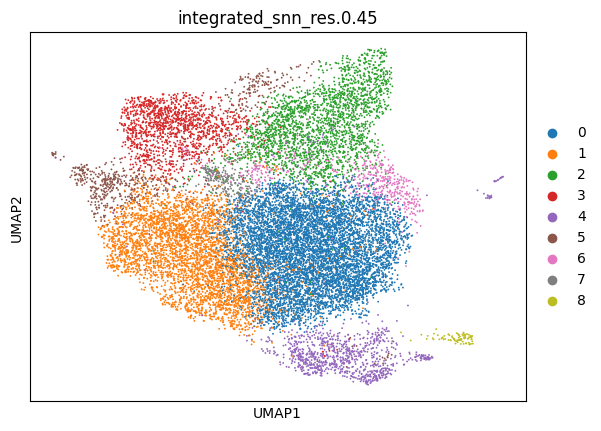

In [4]:
sc.pl.embedding(adata, basis="umap", color="integrated_snn_res.0.45", show=False)

# Senescence geneset scoring
#### Curate geneset pandas dataframes (with genesymbols) from gmt files downloaded from gsea website
#### Run AUCell (upregulation of the geneset)


In [21]:
def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [23]:
SenMayo = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/SAUL_SEN_MAYO.v2024.1.Hs.gmt")
Reactome_sen = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/REACTOME_CELLULAR_SENESCENCE.v2024.1.Hs.gmt")
Fridman_sen = gmt_to_decoupler("/ix/djishnu/Akanksha/datasets/gene_sets/FRIDMAN_SENESCENCE_UP.v2024.1.Hs.gmt")

In [26]:
Fridman_sen

,geneset,genesymbol
0,FRIDMAN_SENESCENCE_UP,ALDH1A3
1,FRIDMAN_SENESCENCE_UP,AOPEP
2,FRIDMAN_SENESCENCE_UP,CCN2
3,FRIDMAN_SENESCENCE_UP,CCND1
4,FRIDMAN_SENESCENCE_UP,CD44
...,...,...
72,FRIDMAN_SENESCENCE_UP,TNFAIP2
73,FRIDMAN_SENESCENCE_UP,TNFAIP3
74,FRIDMAN_SENESCENCE_UP,TP53
75,FRIDMAN_SENESCENCE_UP,TSPYL5


In [29]:
%%time
dc.run_aucell(
    adata,
    Fridman_sen,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

ValueError: No sources with more than min_n=5 targets. Make sure mat and net have shared target features or
        reduce the number assigned to min_n

# SenCID

In [1]:
import pandas as pd
import scipy.sparse as sp
from SenCID.api import SenCID

2024-11-26 07:54:17.457702: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [6]:
# Convert sparse matrix to DataFrame
import pandas as pd
import scipy.sparse as sp

# If adata.X is sparse, convert to dense then DataFrame
if sp.issparse(adata.X):
    counts = pd.DataFrame(
        adata.X.toarray(),
        index=adata.obs_names,
        columns=adata.var_names
    )
else:
    counts = pd.DataFrame(
        adata.X,
        index=adata.obs_names,
        columns=adata.var_names
    )

# Transpose and save
counts = counts.T
counts.to_csv('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_cell_by_gene.txt', sep='\t')

In [24]:
# load csv counts
counts = pd.read_csv('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_cell_by_gene.txt', sep = '\t').T

In [27]:
counts_df = counts
counts_df.columns = counts_df.iloc[0]
# Convert column names to strings first, then uppercase
counts_df.columns = [str(x).upper() for x in counts_df.columns]
counts_df = counts_df.iloc[1:]
counts_df.index.name = None
counts_df.columns.name = None

In [30]:
display(counts_df)

,XKR4,RP1,SOX17,MRPL15,LYPLA1,TCEA1,RGS20,ATP6V1H,OPRK1,NPBWR1,...,UBA1Y,KDM5D,EIF2S3Y,UTY,DDX3Y,USP9Y,ZFY2,RBMY,GM3376,GM20736
020624_Prol_AAACCCAAGATGAAGG-1,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCAAGATTAGTG-1,0.0,0.0,0.0,6.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCAAGGTCATCT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCACAAACCATC-1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Prol_AAACCCACAGACCAAG-1,0.0,0.0,0.0,6.0,1.0,6.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
020624_Tam_TTTGGTTCAGAAGCTG-1,0.0,0.0,0.0,3.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGGTTCATACCAGT-1,0.0,0.0,0.0,3.0,0.0,6.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGGTTGTGACCTGC-1,0.0,0.0,0.0,3.0,2.0,5.0,0.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
020624_Tam_TTTGTTGTCCGAAGGA-1,0.0,0.0,0.0,2.0,1.0,4.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
adata = sc.AnnData(counts_df)
adata.obs['condition'] = [x.split('_')[1]=='Tam' for x in adata.obs_names]

In [32]:
adata

AnnData object with n_obs × n_vars = 17126 × 17052
    obs: 'condition'

In [33]:
display(adata.obs['condition'])

020624_Prol_AAACCCAAGATGAAGG-1    False
020624_Prol_AAACCCAAGATTAGTG-1    False
020624_Prol_AAACCCAAGGTCATCT-1    False
020624_Prol_AAACCCACAAACCATC-1    False
020624_Prol_AAACCCACAGACCAAG-1    False
                                  ...  
020624_Tam_TTTGGTTCAGAAGCTG-1      True
020624_Tam_TTTGGTTCATACCAGT-1      True
020624_Tam_TTTGGTTGTGACCTGC-1      True
020624_Tam_TTTGTTGTCCGAAGGA-1      True
020624_Tam_TTTGTTGTCTGTCTCG-1      True
Name: condition, Length: 17126, dtype: bool

In [34]:
# Convert boolean condition to integer for plotting
adata.obs['condition_int'] = adata.obs['condition'].astype(int)

In [35]:
display(adata.obs['condition_int'])

020624_Prol_AAACCCAAGATGAAGG-1    0
020624_Prol_AAACCCAAGATTAGTG-1    0
020624_Prol_AAACCCAAGGTCATCT-1    0
020624_Prol_AAACCCACAAACCATC-1    0
020624_Prol_AAACCCACAGACCAAG-1    0
                                 ..
020624_Tam_TTTGGTTCAGAAGCTG-1     1
020624_Tam_TTTGGTTCATACCAGT-1     1
020624_Tam_TTTGGTTGTGACCTGC-1     1
020624_Tam_TTTGTTGTCCGAAGGA-1     1
020624_Tam_TTTGTTGTCTGTCTCG-1     1
Name: condition_int, Length: 17126, dtype: int64

In [36]:
pred_dict, recSID, tmpfiles = SenCID(adata = adata, 
                    sidnums = [1,2,3,4,5,6], 
                    denoising = True, 
                    binarize = True, 
                    threads = 1, 
                    savetmp = True)

Scaling data...
No need to convert to array
dca: Successfully preprocessed 1223 genes and 17126 cells.



2024-11-26 08:13:37.649124: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-11-26 08:13:37.651443: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-11-26 08:13:37.772599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.38GiB deviceMemoryBandwidth: 1.41TiB/s
2024-11-26 08:13:37.772772: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1

dca: Calculating reconstructions...
Loading models of SID1...
Making predictions of SID1...
Loading models of SID2...
Making predictions of SID2...
Loading models of SID3...
Making predictions of SID3...
Loading models of SID4...
Making predictions of SID4...
Loading models of SID5...
Making predictions of SID5...
Loading models of SID6...
Making predictions of SID6...
Loading Recommend model...
Finished. Giving SID scores and SID Recommendation...


In [40]:
# save pred_dict dictionary
import pickle
with open('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_SenCID_pred_dict.pkl', 'wb') as f:
    pickle.dump(pred_dict, f)


In [37]:
adata.obs = pd.concat([adata.obs, recSID.loc[adata.obs_names, :]], axis = 1)

In [38]:
# save adata
adata.write('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_SenCID.h5ad')

... storing 'RecSID' as categorical


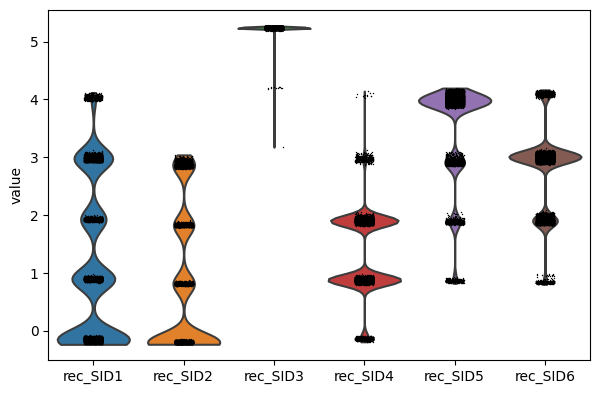

In [41]:
markers = ['rec_SID1', 'rec_SID2', 'rec_SID3', 'rec_SID4', 'rec_SID5', 'rec_SID6']
sc.pl.violin(adata, keys = markers)

In [5]:
# load adata with SID
adata_with_SID = sc.read('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tamoxifen_with_SID.h5ad')
adata_with_SID


AnnData object with n_obs × n_vars = 17126 × 17052
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'S.Score', 'G2M.Score', 'Phase', 'integrated_snn_res.0.2', 'integrated_snn_res.0.25', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'integrated_snn_res.0.5', 'seurat_clusters', 'old.ident', 'integrated_snn_res.0.4', 'integrated_snn_res.0.45', 'integrated_snn_res.0.55', 'integrated_snn_res.0.6', 'Treatment', 'cluster.treatment', 'condition', 'condition_int', 'RecSID', 'rec_SID1', 'rec_SID2', 'rec_SID3', 'rec_SID4', 'rec_SID5', 'rec_SID6'
    uns: 'integrated_snn_res.0.45_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
# load pred_dict from pickle file
import pickle
with open('/ix/djishnu/Akanksha/datasets/senescence_fibroblasts/tam_SenCID_pred_dict.pkl', 'rb') as f:
    pred_dict = pickle.load(f)
pred_dict


{'SID1':                                 SID_Score  Decision  Binarization
 020624_Prol_AAACCCAAGATGAAGG-1   0.132403 -0.529981           0.0
 020624_Prol_AAACCCAAGATTAGTG-1   0.043374 -0.998756           0.0
 020624_Prol_AAACCCAAGGTCATCT-1   0.154095 -0.503229           0.0
 020624_Prol_AAACCCACAAACCATC-1   0.253527 -0.263015           0.0
 020624_Prol_AAACCCACAGACCAAG-1   0.063664 -0.889003           0.0
 ...                                   ...       ...           ...
 020624_Tam_TTTGGTTCAGAAGCTG-1    0.213338 -0.406173           0.0
 020624_Tam_TTTGGTTCATACCAGT-1    0.041675 -1.062946           0.0
 020624_Tam_TTTGGTTGTGACCTGC-1    0.575561  0.230774           1.0
 020624_Tam_TTTGTTGTCCGAAGGA-1    0.314806 -0.216850           0.0
 020624_Tam_TTTGTTGTCTGTCTCG-1    0.194982 -0.491982           0.0
 
 [17126 rows x 3 columns],
 'SID2':                                 SID_Score  Decision  Binarization
 020624_Prol_AAACCCAAGATGAAGG-1   0.004497 -2.940914           0.0
 020624_Prol_AAAC

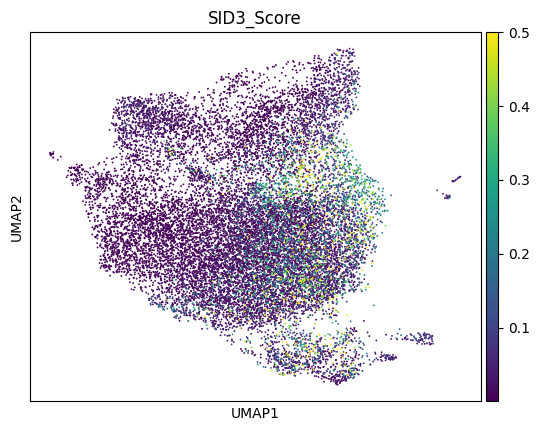

In [12]:
adata.obs['SID3_Score'] = pred_dict['SID3'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID3_Score'], color_map = 'viridis', vmax = 0.5)


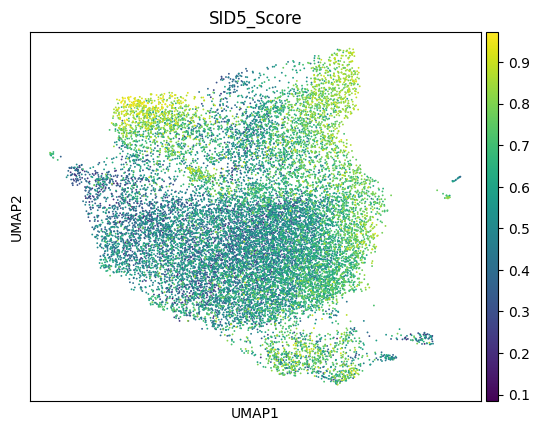

In [16]:
adata.obs['SID5_Score'] = pred_dict['SID5'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID5_Score'], color_map = 'viridis')


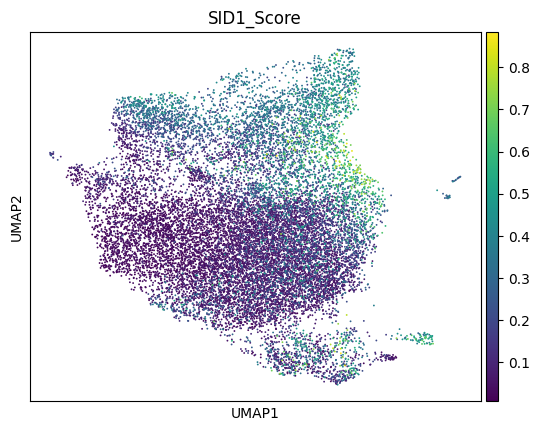

In [17]:
adata.obs['SID1_Score'] = pred_dict['SID1'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID1_Score'], color_map = 'viridis')


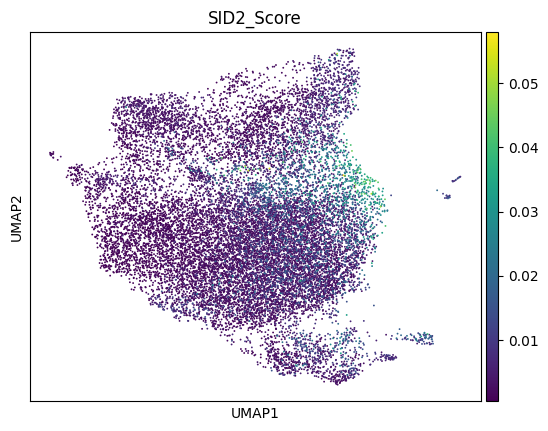

In [18]:
adata.obs['SID2_Score'] = pred_dict['SID2'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID2_Score'], color_map = 'viridis')



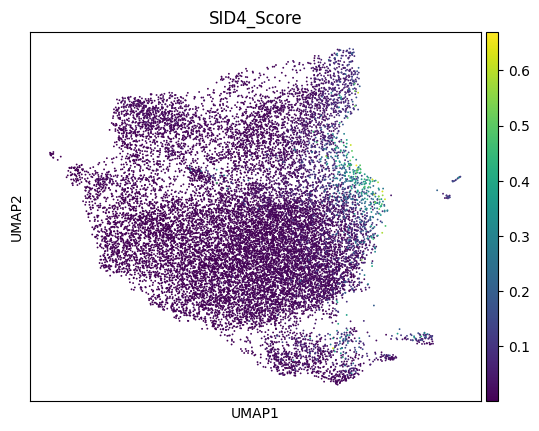

In [19]:
adata.obs['SID4_Score'] = pred_dict['SID4'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID4_Score'], color_map = 'viridis')


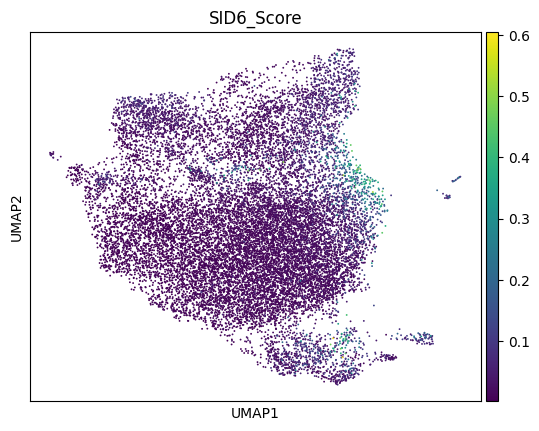

In [20]:
adata.obs['SID6_Score'] = pred_dict['SID6'].loc[adata.obs_names, 'SID_Score']
# color bar should have min and max of the score values 
sc.pl.umap(adata, color = ['SID6_Score'], color_map = 'viridis')
